In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib.ticker import MaxNLocator
from scipy.signal import detrend
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(8, 4)})
sns.set_style("whitegrid", {'axes.grid' : False})

df = pd.read_csv('cultivable_pca.csv')
df['Date'] = pd.to_datetime(df['Date'])

features = df.iloc[:, 13:]
cols = features.columns.tolist()

In [3]:
emi2 = [18, 59, 57]
# multitask = [40, 36, 25, 52, 1, 21, 35, 31, 22, 51]

ds = df[[cols[i] for i in emi2] + ['anomalia_emiliani2']]

ds['anomalia_emiliani2'] = detrend(ds['anomalia_emiliani2'])
#ds['anomalia_emiliani2_t'] = ds['anomalia_emiliani2'].shift(1)
#ds['anomalia_emiliani2_t-1'] = ds['anomalia_emiliani2'].shift(2)

In [4]:
columns = ds.columns.tolist()
for col in columns[:3]:
    for i in range(1,24):
        ds[col+'_t-'+str(i)] = ds[col].shift(i)
        
ds = ds.iloc[25:].reset_index(drop=True)

pcs = ds.filter(regex='PC')
anomalia = ds.filter(regex='emiliani2')
ds = ds[pcs.columns.tolist() + anomalia.columns.tolist()[1:] + anomalia.columns.tolist()[0:1]]

In [5]:
# divide into train/val/test sets
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

scaler = StandardScaler()
scaler.fit(train)
ds[ds.columns] = scaler.transform(ds[ds.columns])

# update train/val/test sets
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

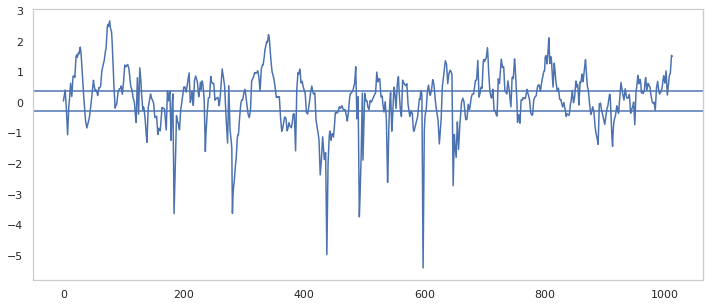

In [6]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.axhline(train.anomalia_emiliani2.quantile(0.33), label='33% quantile')
plt.axhline(train.anomalia_emiliani2.quantile(0.66), label='66% quantile')
plt.plot(ds.anomalia_emiliani2)


In [7]:
# Calcolo dei terzili

y_min = train.anomalia_emiliani2.quantile(0.33)
y_max = train.anomalia_emiliani2.quantile(0.66)

In [8]:
train_data = train.anomalia_emiliani2
val_data = validation.anomalia_emiliani2
test_data  = test.anomalia_emiliani2


train['Label'] = train_data.apply(lambda x: 1 if x>y_max else -1 if x<y_min else 0)
validation['Label'] = val_data.apply(lambda x: 1 if x>y_max else -1 if x<y_min else 0)
test['Label'] = test_data.apply(lambda x: 1 if x>y_max else -1 if x<y_min else 0)

In [54]:
X_train = train.iloc[:, :72].values
y_train = train.iloc[:, -1].values

X_val = validation.iloc[:, :72].values
y_val = validation.iloc[:, -1].values

X_test = test.iloc[:, :72].values
y_test = test.iloc[:, -1].values

In [10]:
def plot_conmat(true, pred, title, ax):
    conmat = confusion_matrix(true, pred)
    val = np.mat(conmat) 

    classnames = ['Normal', 'Good', 'Bad']

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    #df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]  
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df_cm.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    if title is not None : ax.set_title(title)
    #plt.show()  


##### Modello Random Forest

In [11]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [48]:
from hypopt import GridSearch #libreria per fare cv con validation set definito

ext = ExtraTreesClassifier()
opt = GridSearch(model = ext, param_grid = random_grid)

opt.fit(X_train, y_train, X_val, y_val)

100%|██████████| 480/480 [00:00<00:00, 10416.16it/s]


ValueError: not enough values to unpack (expected 2, got 0)

In [13]:
train_val = pd.concat([train,validation])

best_rf = opt.best_estimator_
best_rf.fit(train_val.iloc[int(len(train_val)*0.2):, :72].values, train_val.iloc[int(len(train_val)*0.2):, -1].values)

ExtraTreesClassifier(bootstrap=True, max_depth=10, min_samples_split=5,
                     random_state=0)

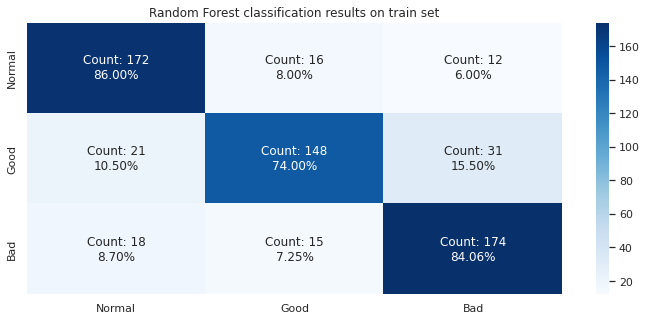

In [14]:
fig,ax=plt.subplots()
plot_conmat(y_train, opt.predict(X_train), 'Random Forest classification results on train set', ax=ax)

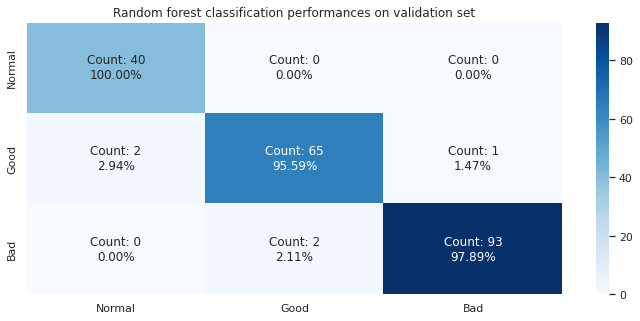

In [15]:
fig,ax=plt.subplots()
plot_conmat(validation.iloc[:, -1].values, opt.predict(X_val), 'Random forest classification performances on validation set', ax=ax)

In [16]:
train_val = pd.concat([train,validation])

best_rf = opt.best_estimator_

In [17]:
best_rf.score(X_test, y_test)

0.39408866995073893

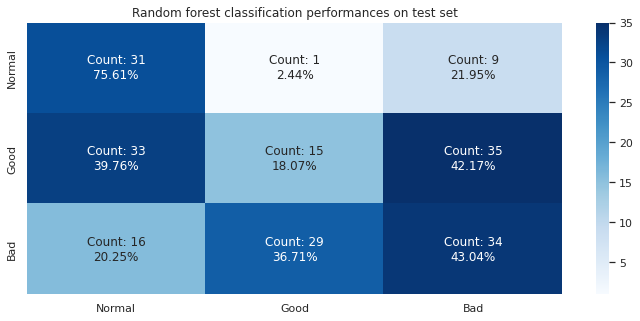

In [18]:
fig, ax = plt.subplots()
plot_conmat(y_test, best_rf.predict(X_test), 'Random forest classification performances on test set', ax=ax)
plt.savefig('imgs/random_forest_classification_singletask.eps', format='eps')

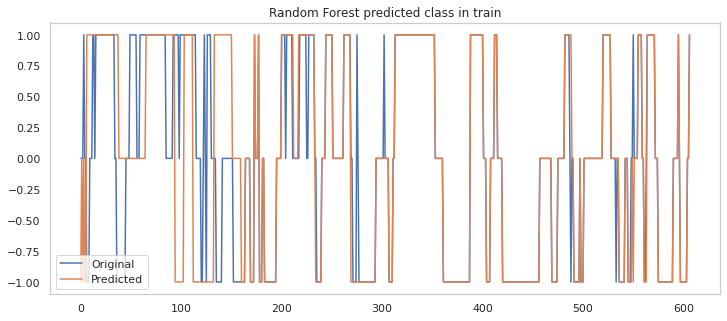

In [19]:
plt.plot(y_train, label='Original')
plt.title('Random Forest predicted class in train')
plt.plot(opt.predict(X_train), label='Predicted')
plt.legend()
plt.show()

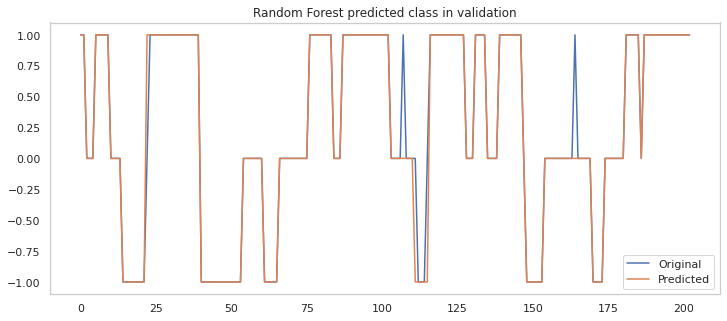

In [20]:
plt.plot(validation.iloc[:, -1].values, label='Original')
plt.title('Random Forest predicted class in validation')
plt.plot(opt.predict(X_val), label='Predicted')
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


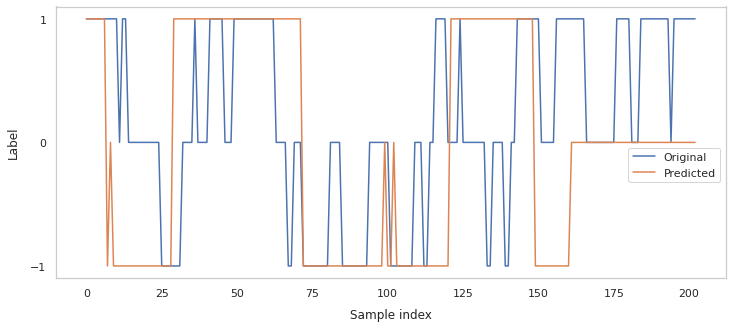

In [21]:
fig, ax= plt.subplots()

plt.plot(y_test, label='Original')
#plt.title('Random Forest predicted class in test')
plt.plot(best_rf.predict(X_test), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('Sample index', labelpad=10)
plt.ylabel('Label', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('imgs/curves_randomforest_singletask.eps', format='eps')
plt.show()

## Feed forward

In [49]:
def feed_forward():
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
y_train = train.iloc[:, -1]
y_validation = validation.iloc[:, -1]
y_test = test.iloc[:, -1]

In [57]:
y_train = np.eye(3)[y_train]
y_validation = np.eye(3)[y_validation]
y_test = np.eye(3)[y_test]

In [58]:
model = feed_forward()

history = model.fit(X_train, y_train, validation_data = (X_val, y_validation), shuffle=False, epochs=35, verbose=0)

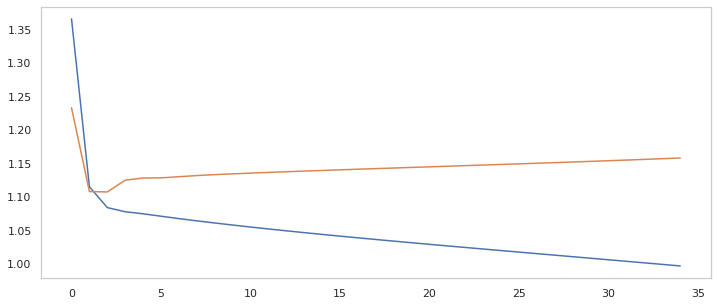

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [60]:
train_val = pd.concat([train,validation])
train_y = np.eye(3)[train_val.iloc[:, -1]]

model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 2ms/step - loss: 1.0098 - accuracy: 0.5764


[1.009800672531128, 0.5763546824455261]

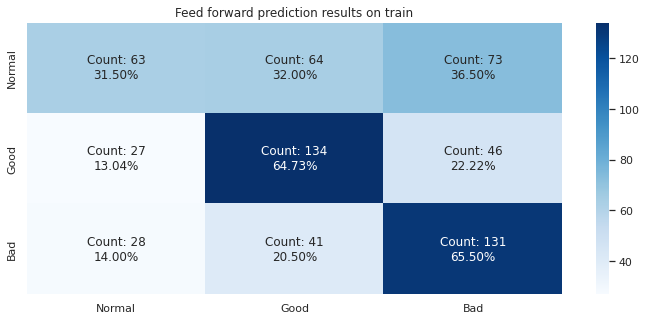

In [28]:
fig,ax = plt.subplots()
plot_conmat(y_train.argmax(axis=1), model.predict(X_train).argmax(axis=1), 'Feed forward prediction results on train', ax=ax)

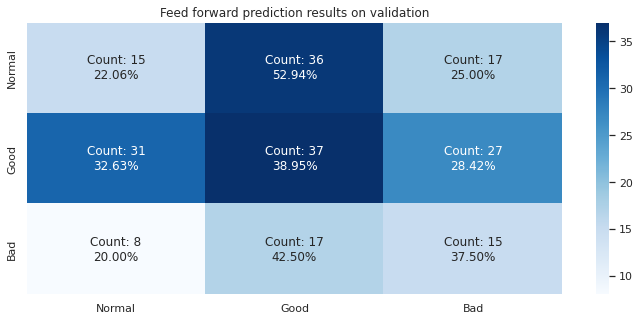

In [29]:
fig,ax = plt.subplots()
plot_conmat(y_validation.argmax(axis=1), model.predict(X_val).argmax(axis=1), 'Feed forward prediction results on validation', ax=ax)

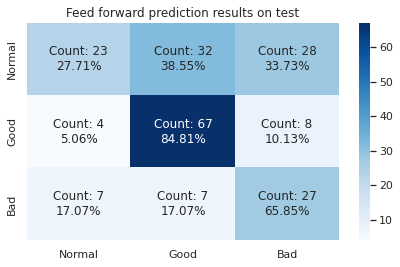

In [61]:
fig, ax = plt.subplots(figsize=(7,4))
plot_conmat(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1), 'Feed forward prediction results on test', ax=ax)
plt.savefig('imgs/classification_feedforward_singletask.eps', format='eps')

In [63]:
trues_test = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_test.argmax(axis=1)))
preds = list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_test).argmax(axis=1)))

In [65]:
import pickle 

with open('preds_st_ffnn.pickle', 'wb') as f: pickle.dump(preds,f)

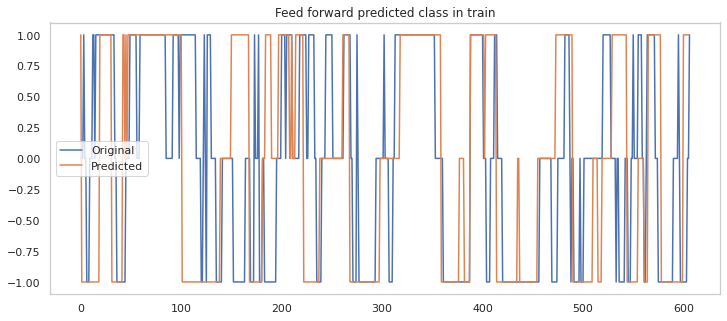

In [32]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_train.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_train).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

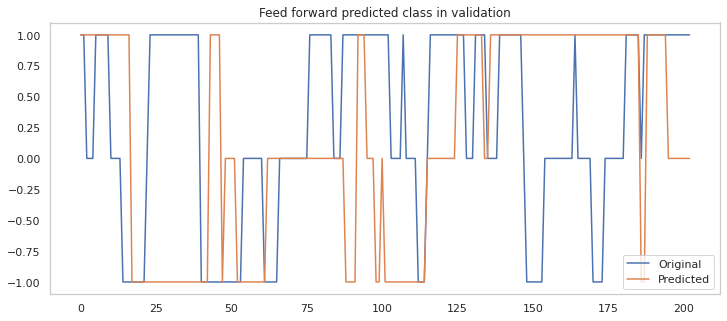

In [33]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_validation.argmax(axis=1))), label='Original')
plt.title('Feed forward predicted class in validation')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_val).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


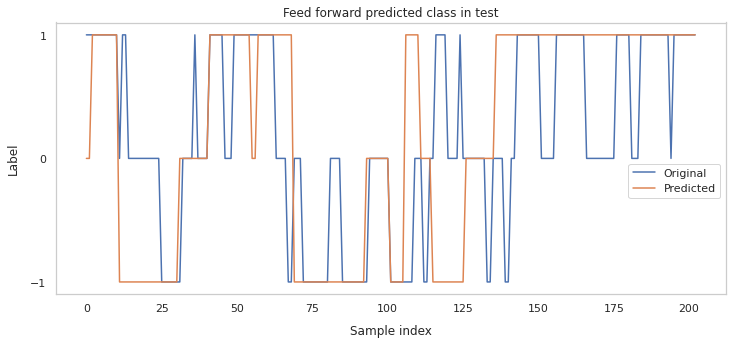

In [34]:
fig, ax = plt.subplots()
plt.plot(trues_test, label='Original')
plt.title('Feed forward predicted class in test')
plt.plot(preds, label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('Sample index', labelpad=10)
plt.ylabel('Label', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('imgs/curves_feedforward_singletask.eps', format='eps')
plt.show()

## Recurrent


In [35]:
def rnn(HISTORY_SIZE, OUT_STEPS, n_features):
  model = tf.keras.Sequential([
      tf.keras.layers.SimpleRNN(
        units=64,
        input_shape=(HISTORY_SIZE, n_features),
        return_sequences=True # True nel multitask
      ),
     #tf.keras.layers.Lambda(lambda x: x[:, -pred_steps:, :]), #Select last N from output [multitask]
     tf.keras.layers.Dense(OUT_STEPS, activation='softmax')
     ])

  model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
  )

  return model

In [36]:
train_labels = np.eye(3)[train['Label']] # [a ,b ,c] dove a: 0, b:1, c:-1
validation_labels = np.eye(3)[validation['Label']]
test_labels = np.eye(3)[test['Label']]

In [37]:
def classification_series(series, labels, n_past, n_future, offset=1, hist=True):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  # offset ==> window stride

  X = []
  y = []

  for window_start in range(len(series)):
    past_end = window_start*offset + n_past 
    future_end = past_end + n_future
    if future_end > len(series):
      break

    if hist:
      past, future = series[window_start*offset:past_end, :72], labels[window_start*offset:past_end]
    else:
      past, future = series[window_start*offset:past_end, [0,1,2]], labels[window_start*offset:past_end] 
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [38]:
seq_length = 5
X_train, y_train = classification_series(train.values, train_labels, seq_length, 1, seq_length, hist=True)
X_val, y_val = classification_series(validation.values, validation_labels, seq_length, 1, seq_length, hist=True)
X_test, y_test = classification_series(test.values, test_labels, seq_length, 1, seq_length, hist=True)

In [39]:
model = rnn(5, 3, 72)
model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=False, epochs=50, batch_size=5)

Epoch 1/50
25/25 [==============================] - 2s 18ms/step - loss: 1.3288 - accuracy: 0.2612 - val_loss: 1.1529 - val_accuracy: 0.3300
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 1.1253 - accuracy: 0.3802 - val_loss: 1.1731 - val_accuracy: 0.3400
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 1.0778 - accuracy: 0.4050 - val_loss: 1.1479 - val_accuracy: 0.3650
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 1.0476 - accuracy: 0.4182 - val_loss: 1.1585 - val_accuracy: 0.3400
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 1.0226 - accuracy: 0.4727 - val_loss: 1.1696 - val_accuracy: 0.3500
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 1.0033 - accuracy: 0.5058 - val_loss: 1.1804 - val_accuracy: 0.3350
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.9855 - accuracy: 0.5223 - val_loss: 1.1911 - val_accuracy: 0.3150
Epoch 8/50
25/25 [=

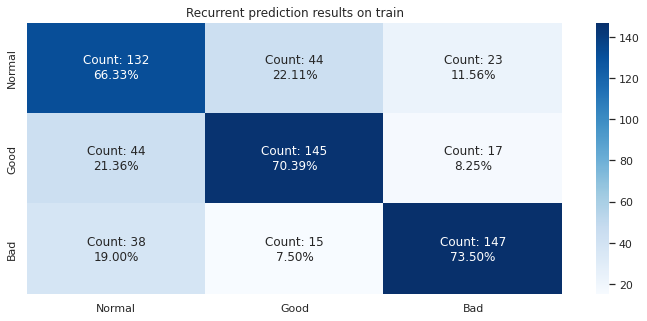

In [40]:
fig,ax=plt.subplots()
plot_conmat(y_train.reshape(605,3).argmax(axis=1), model.predict(X_train).reshape(605,3).argmax(axis=1), 'Recurrent prediction results on train', ax=ax)

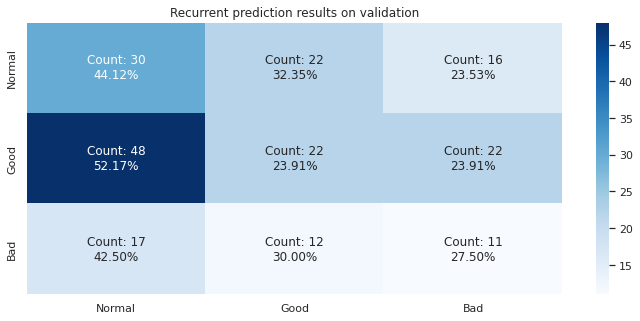

In [41]:
fig,ax=plt.subplots()
plot_conmat(y_val.reshape(200,3).argmax(axis=1), model.predict(X_val).reshape(200,3).argmax(axis=1), 'Recurrent prediction results on validation', ax=ax)

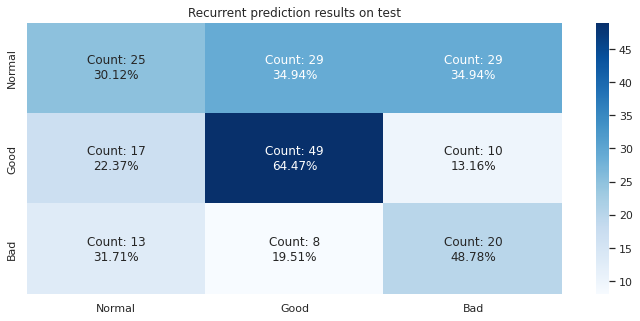

In [42]:
fig, ax= plt.subplots()
plot_conmat(y_test.reshape(200,3).argmax(axis=1), model.predict(X_test).reshape(200,3).argmax(axis=1), 'Recurrent prediction results on test', ax=ax)
plt.savefig('imgs/classification_recurrent_singletask.eps', format='eps')

In [43]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 1.5359 - accuracy: 0.4700


[1.5359288454055786, 0.4699999988079071]

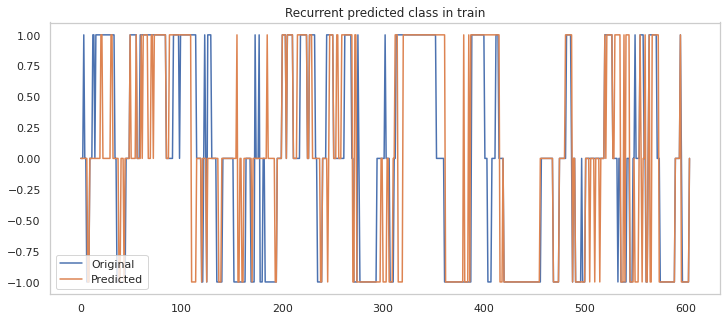

In [44]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_train.reshape(605,3).argmax(axis=1))), label='Original')
plt.title('Recurrent predicted class in train')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_train).reshape(605,3).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

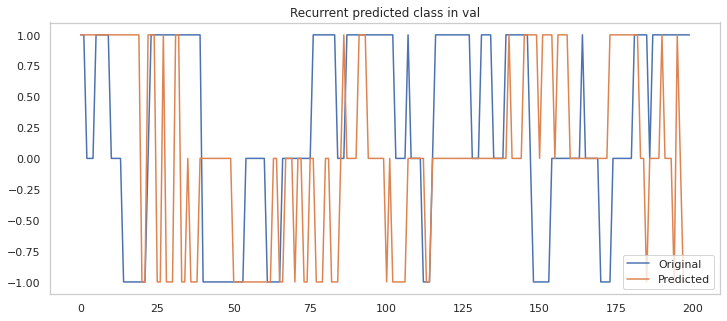

In [45]:
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_val.reshape(200,3).argmax(axis=1))), label='Original')
plt.title('Recurrent predicted class in val')
plt.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_val).reshape(200,3).argmax(axis=1))), label='Predicted')
plt.legend()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


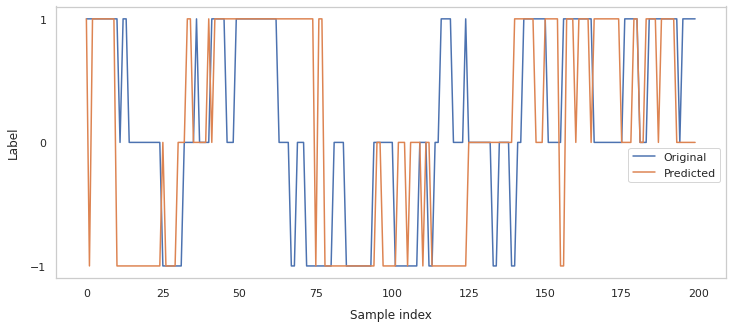

In [46]:
fig,ax = plt.subplots()

ax.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, y_test.reshape(200,3).argmax(axis=1))), label='Original')
#plt.title('Recurrent predicted class in test')
ax.plot(list(map(lambda x: 0 if x==0 else 1 if x==1 else -1, model.predict(X_test).reshape(200,3).argmax(axis=1))), label='Predicted')
plt.legend(bbox_to_anchor=(1, 0.5))
plt.xlabel('Sample index', labelpad=10)
plt.ylabel('Label', labelpad=10)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#plt.figure().gca().set_major_locator(MaxNLocator(integer=True))
plt.savefig('imgs/curves_recurrent_singletask.eps', format='eps')
plt.show()

# 